# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [52]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot, lineplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_series_hist_acf_kpss(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=Yt, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Compare median and mean
    print(Yt.describe())

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(Yt, regression='c', store=True)    # hypothesis: constant
    "KPSS={}".format(kpss_stat)# around a mean

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=Yt, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': y_pred.abs().max(),
        'MIN_ABS': y_pred.abs().min()}


def model_errors(y: Series, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

# Preprocessing
Feature engineering, create categorial columns

In [53]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

# get data for one store
df_train = df_train.groupby(by='Store').get_group(2).set_index('Date')
# FEATURE ENGINEERING
## StateHoliday -> categorial
df_train['StateHoliday'] = df_train['StateHoliday'].astype('category')
## StateHoliday -> dummy variable
df_train = pd.concat([df_train, pd.get_dummies(df_train['StateHoliday'], prefix='StateHoliday', dtype=bool)], axis=1)
#df_train.groupby(by=['StateHoliday']).get_group('a')

## Day of week -> categorial
df_train['DayOfWeek'] = df_train['DayOfWeek'].astype('category')
df_train = pd.concat([df_train, pd.get_dummies(df_train['DayOfWeek'], prefix='DayOfWeek', dtype=bool)], axis=1)

df_train.info()
df_train.head(5)

X = df_train[['Promo',
              'SchoolHoliday',
              'StateHoliday_0',
              'StateHoliday_a',
              'StateHoliday_b',
              'StateHoliday_c',
              'DayOfWeek_1',
              'DayOfWeek_2',
              'DayOfWeek_3',
              'DayOfWeek_4',
              'DayOfWeek_5',
              'DayOfWeek_6',
              'DayOfWeek_7']]
Y = df_train['Sales']

X.info()
X.head(5)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2015-07-31 to 2013-01-01
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Store           942 non-null    object        
 1   DayOfWeek       942 non-null    category      
 2   Date            942 non-null    datetime64[ns]
 3   Sales           942 non-null    object        
 4   Customers       942 non-null    object        
 5   Open            942 non-null    object        
 6   Promo           942 non-null    object        
 7   StateHoliday    942 non-null    category      
 8   SchoolHoliday   942 non-null    object        
 9   StateHoliday_0  942 non-null    bool          
 10  StateHoliday_a  942 non-null    bool          
 11  StateHoliday_b  942 non-null    bool          
 12  StateHoliday_c  942 non-null    bool          
 13  DayOfWeek_1     942 non-null    bool          
 14  DayOfWeek_2     942 non-null    bool   

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,,,,,,,,,,
2015-07-31,2,5,2015-07-31,6064,625,True,True,0,True,True,False,False,False,False,False,False,False,True,False,False
2015-07-30,2,4,2015-07-30,5567,601,True,True,0,True,True,False,False,False,False,False,False,True,False,False,False
2015-07-29,2,3,2015-07-29,6402,727,True,True,0,True,True,False,False,False,False,False,True,False,False,False,False
2015-07-28,2,2,2015-07-28,5671,646,True,True,0,True,True,False,False,False,False,True,False,False,False,False,False
2015-07-27,2,1,2015-07-27,6627,638,True,True,0,True,True,False,False,False,True,False,False,False,False,False,False


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Promo           942 non-null    object
 1   SchoolHoliday   942 non-null    object
 2   StateHoliday_0  942 non-null    bool  
 3   StateHoliday_a  942 non-null    bool  
 4   StateHoliday_b  942 non-null    bool  
 5   StateHoliday_c  942 non-null    bool  
 6   DayOfWeek_1     942 non-null    bool  
 7   DayOfWeek_2     942 non-null    bool  
 8   DayOfWeek_3     942 non-null    bool  
 9   DayOfWeek_4     942 non-null    bool  
 10  DayOfWeek_5     942 non-null    bool  
 11  DayOfWeek_6     942 non-null    bool  
 12  DayOfWeek_7     942 non-null    bool  
dtypes: bool(11), object(2)
memory usage: 32.2+ KB


,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,,,
2015-07-31,True,True,True,False,False,False,False,False,False,False,True,False,False
2015-07-30,True,True,True,False,False,False,False,False,False,True,False,False,False
2015-07-29,True,True,True,False,False,False,False,False,True,False,False,False,False
2015-07-28,True,True,True,False,False,False,False,True,False,False,False,False,False
2015-07-27,True,True,True,False,False,False,True,False,False,False,False,False,False


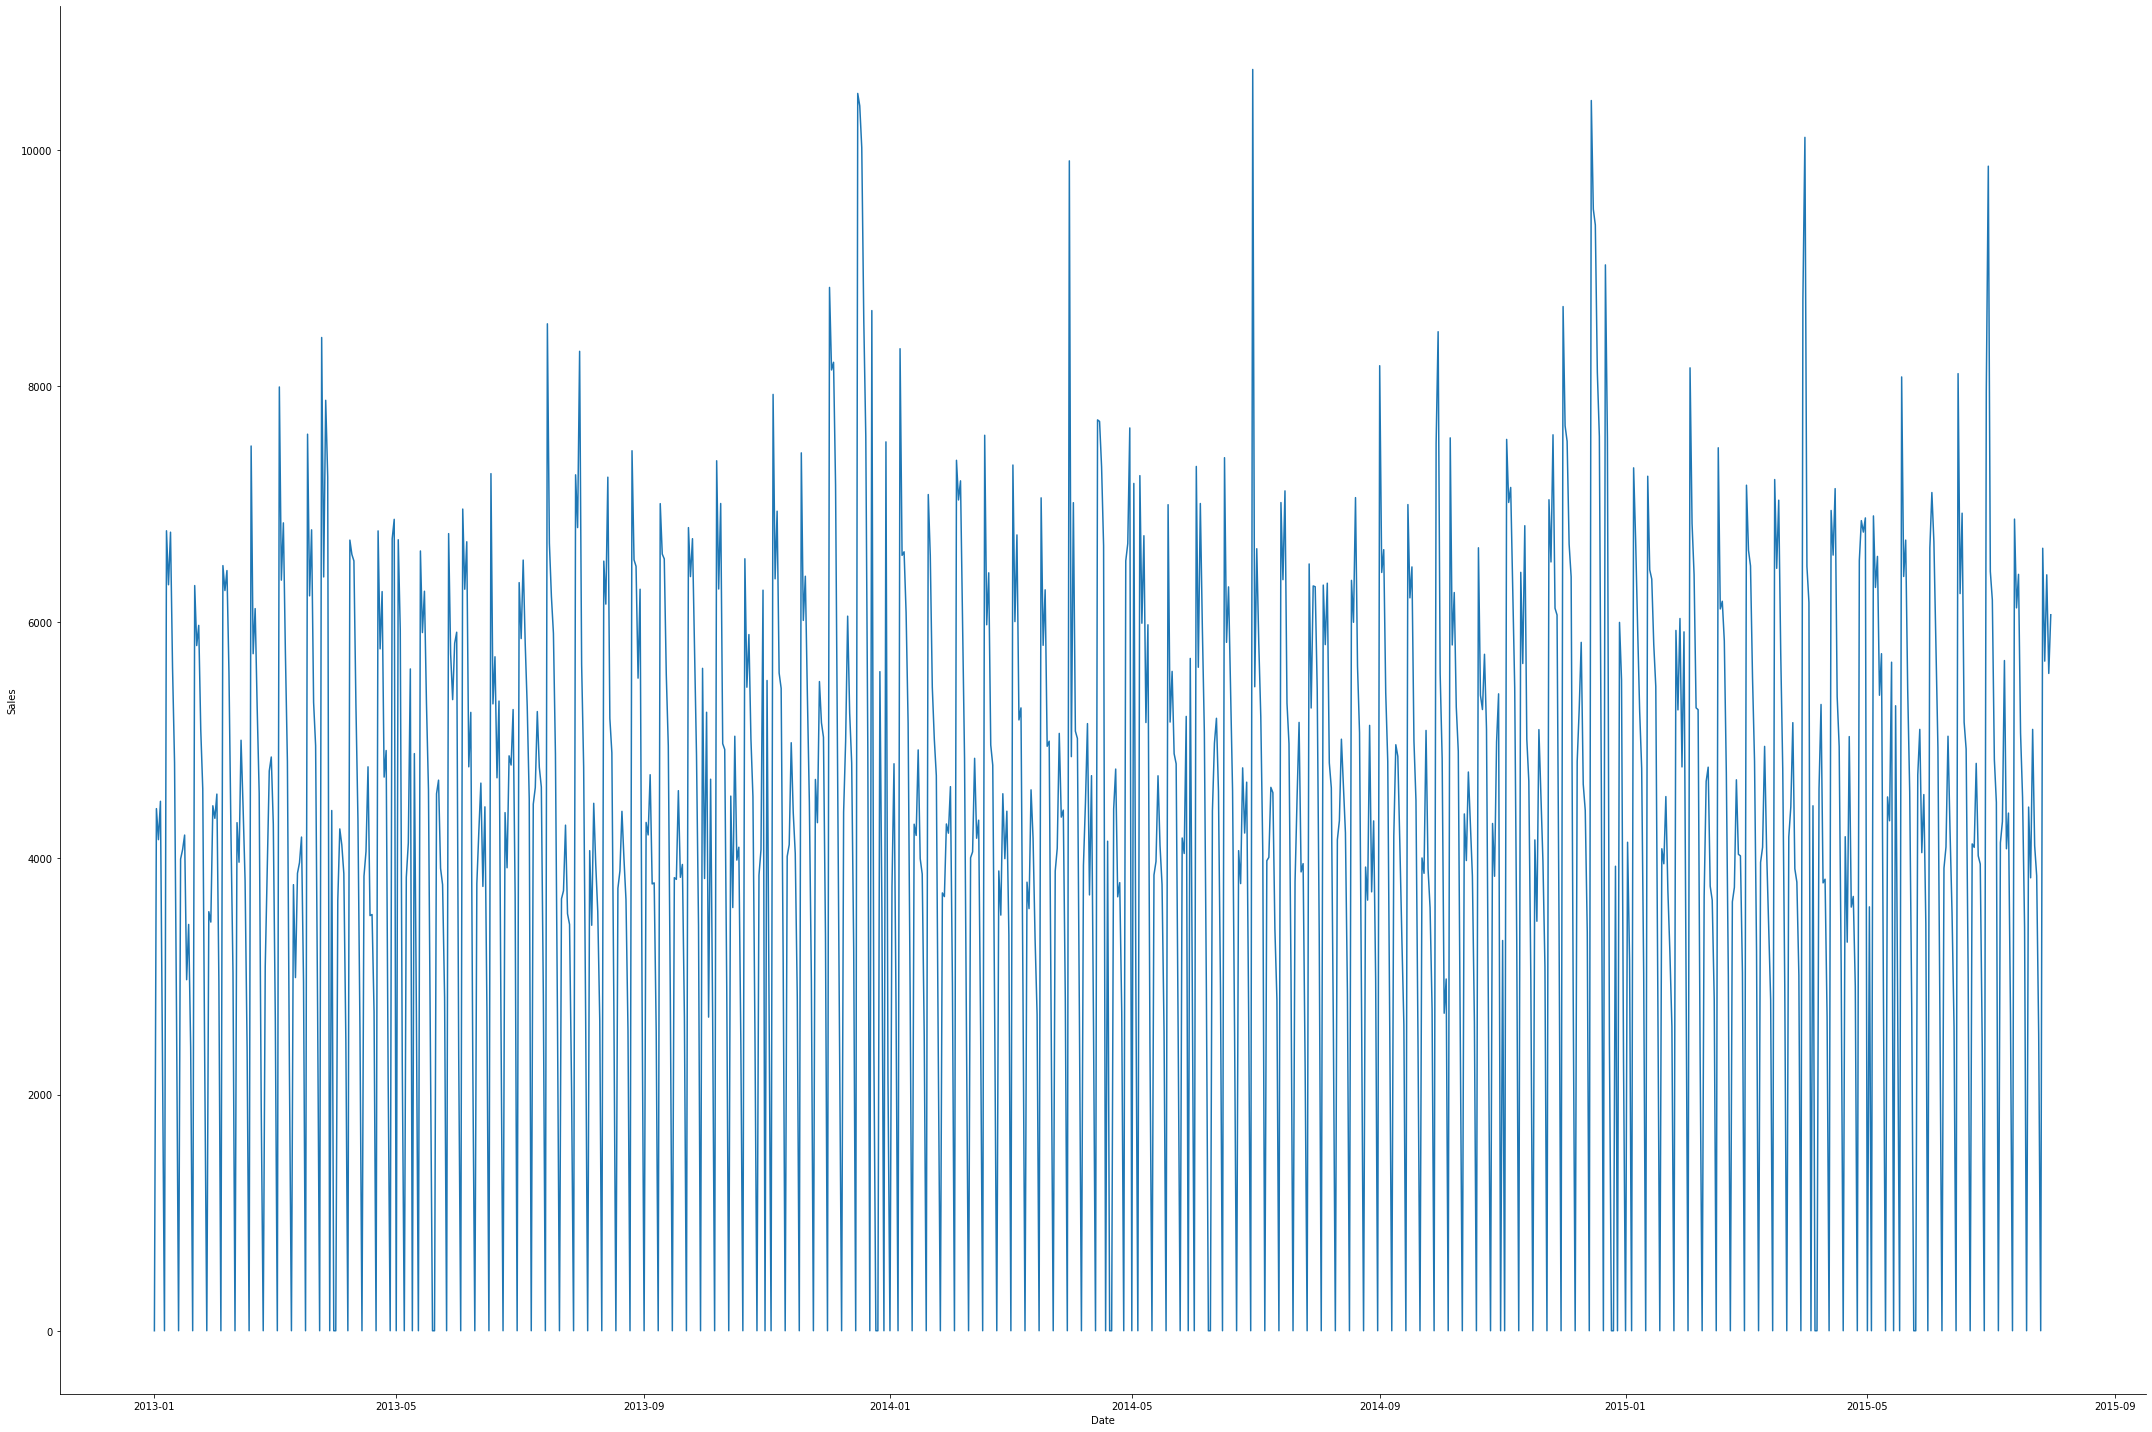

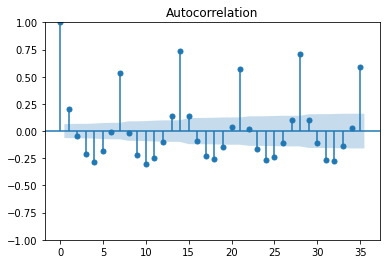

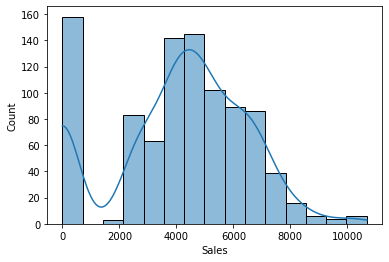

count     942
unique    720
top         0
freq      158
Name: Sales, dtype: int64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [55]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plot_series_hist_acf_kpss(Y, lags=35)

# Forecast | Oridinary least squares
Naively assume we can forecast by OLS and interpret the residuals of the model.

In [ ]:
from statsmodels.regression.linear_model import OLS, RegressionResults

model: OLS = OLS(Y, X)
model_fit: RegressionResults = model.fit()

model_fit.summary()

plot_actual_and_fitted_values(Y.iloc[:60], model_fit)

model_errors(Y, model_fit)